In [227]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [228]:
%matplotlib inline

In [265]:
from model.cae import CAE

from utils import plot_paired_imgs
from utils import plot_sample_imgs
from utils import read_images

import os

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

In [230]:
from datetime import datetime

In [231]:
from keras.callbacks import TensorBoard
from keras.preprocessing.image import ImageDataGenerator

__Read data__

In [234]:
DATA_PATH = '/home/jupyter/data/mnist'
PNG_PATH = os.path.join(DATA_PATH, 'png')

In [235]:
train_df = pd.read_csv(os.path.join(DATA_PATH, 'train.csv'), sep='|')
test_df = pd.read_csv(os.path.join(DATA_PATH, 'test.csv'), sep='|')

In [236]:
train_df.head(5)

,label,filename
0,5,train_00000.png
1,0,train_00001.png
2,4,train_00002.png
3,1,train_00003.png
4,9,train_00004.png


In [237]:
test_df.head(5)

,label,filename
0,7,test_00000.png
1,2,test_00001.png
2,1,test_00002.png
3,0,test_00003.png
4,4,test_00004.png


In [277]:
images_train_sample = read_images(train_df['filename'].iloc[:100], PNG_PATH)

100%|██████████| 100/100 [00:00<00:00, 10276.88imgs/s]


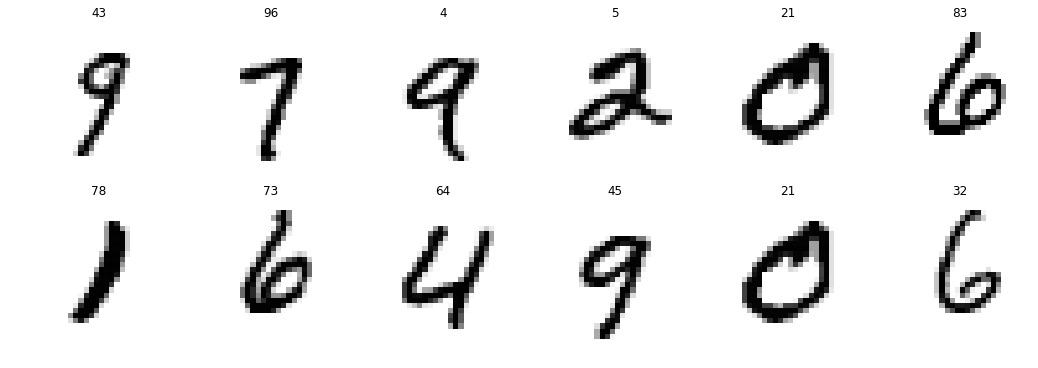

In [278]:
plot_sample_imgs(images_train_sample, 2, 6)

**Prepare data**

In [279]:
BATCH_SIZE = 32
EPOCHS = 20
IMAGE_SIZE = 28
SEED = 1993

In [280]:
train_datagen = ImageDataGenerator(validation_split=0.2, rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(train_df, directory=PNG_PATH + '/', x_col='filename', 
                                                    target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode='rgb', class_mode='input', 
                                                    batch_size=BATCH_SIZE, subset='training', seed=SEED)

validation_generator = train_datagen.flow_from_dataframe(train_df, directory=PNG_PATH, x_col='filename', 
                                                         target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode='rgb', class_mode='input', 
                                                         batch_size=BATCH_SIZE, subset='validation', seed=SEED)

Found 40000 images.
Found 10000 images.


In [255]:
test_df = test_df.iloc[:1000]

In [256]:
test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_dataframe(test_df, directory=PNG_PATH, x_col='filename', 
                                                  target_size=(IMAGE_SIZE, IMAGE_SIZE), color_mode='rgb', class_mode='input', 
                                                  batch_size=1, seed=SEED)

Found 1000 images.


__Train model__

In [16]:
# initialize ConvAutoEncoder model
cae = CAE(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), output_dim=20, filters=[8,16], 
          path='/home/jupyter/data/model')

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
tb = TensorBoard(log_dir='./logs/mnist' + datetime.now().strftime('%Y%m%d_%H%M'), 
                 write_grads=True, write_images=True, histogram_freq=0)

In [18]:
cae.model.fit_generator(generator = train_generator, 
                        validation_data = validation_generator,
                        steps_per_epoch = len(train_generator),
                        validation_steps = len(validation_generator),
                        epochs = EPOCHS, 
                        callbacks = [tb])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
1250/1250 [==============================] - 71s 57ms/step - loss: 0.0438 - val_loss: 0.0240
Epoch 2/20
1250/1250 [==============================] - 54s 43ms/step - loss: 0.0218 - val_loss: 0.0196
Epoch 3/20
1250/1250 [==============================] - 53s 43ms/step - loss: 0.0189 - val_loss: 0.0176
Epoch 4/20
1250/1250 [==============================] - 54s 43ms/step - loss: 0.0174 - val_loss: 0.0165
Epoch 5/20
1250/1250 [==============================] - 54s 43ms/step - loss: 0.0164 - val_loss: 0.0158
Epoch 6/20
1250/1250 [==============================] - 53s 42ms/step - loss: 0.0157 - val_loss: 0.0152
Epoch 7/20
1250/1250 [==============================] - 53s 43ms/step - loss: 0.0152 - val_loss: 0.0149
Epoch 8/20
1250/1250 [==============================] - 54s 43ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 9/20
1250/1250 [==============================] - 53s 43ms/step - loss: 0.0144 - val_loss: 0.0141
Epoch 10/20
1250

__Run Predictions__

In [258]:
%%time
cae.model.evaluate_generator(test_generator, len(test_generator))

CPU times: user 4.03 s, sys: 364 ms, total: 4.4 s
Wall time: 1.93 s


0.010934267574455588

In [260]:
%%time
X_test_enc = cae.encoder.predict_generator(test_generator, len(test_generator))

CPU times: user 3.26 s, sys: 340 ms, total: 3.6 s
Wall time: 1.79 s


In [284]:
X_test_enc[:4]

array([[ 7.1119413,  2.2488925,  8.896568 ,  8.092659 ,  0.       ,
        11.685453 ,  1.0150276, 10.145022 ,  4.2573028,  0.       ,
         3.7214804,  8.481744 ,  2.755852 , 11.382693 ,  9.281883 ,
         2.8407373,  5.00479  ,  3.4740176,  1.0237017,  0.       ],
       [ 9.366047 ,  8.778297 ,  3.9923596,  6.008081 ,  0.       ,
         7.1506047,  5.020612 ,  1.1689605,  5.7982187,  0.       ,
         5.950869 ,  2.7156963,  4.262079 ,  3.2129347,  9.791313 ,
         7.003344 ,  3.1389635,  4.073145 ,  3.582332 ,  0.       ],
       [ 8.681977 ,  6.252889 ,  1.3877904,  6.824855 ,  0.       ,
         5.76086  ,  8.179815 ,  0.       ,  2.0679357,  0.       ,
         4.8355904,  6.6277266,  0.3629095,  2.8757715,  7.785982 ,
         6.2500205,  2.335654 ,  3.6849444,  1.2520776,  0.       ],
       [ 7.1616855,  7.00179  ,  7.0483665,  3.444038 ,  0.       ,
         4.774093 , 10.231929 ,  1.840922 ,  1.7121958,  0.       ,
         6.132911 ,  5.6907444,  3.56074  ,  

In [262]:
X_test_enc.shape

(1000, 20)

In [281]:
X_test = read_images(test_df['filename'].values, PNG_PATH)

100%|██████████| 1000/1000 [00:00<00:00, 14235.93imgs/s]


In [282]:
X_test_pred = cae.model.predict(X_test)

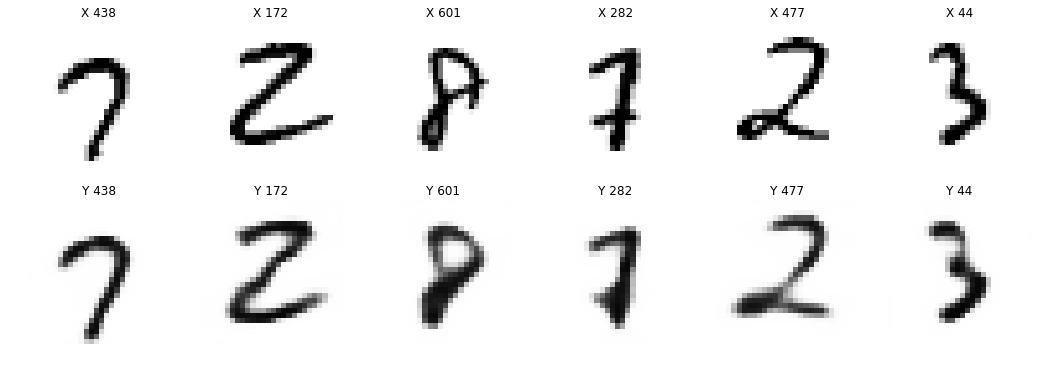

In [283]:
plot_paired_imgs(X_test, X_test_pred, N=6, orient='h')